In [ ]:
# Sale probability prediction model based in Pytorch optimized for Mac M1 chip

In [1]:
# imports
# !pip install torch 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import datetime 

In [2]:
def displayDataFrame(df_to_display, all_frame=False):
    if all_frame:
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
            display(df_to_display)
    else:
        display(df_to_display)

In [3]:
# read data
area_codes_df = pd.read_excel('/Users/e.vargas/Desktop/Lead Routing/areacodes.xlsx', header=None)
displayDataFrame(area_codes_df, all_frame=False)

leads_df = pd.read_csv('/Users/e.vargas/Desktop/Lead Routing/all_calls_2021.csv', 
                    parse_dates=['callDate','callStartTime'])
displayDataFrame(leads_df, all_frame=False)

leads_source_map = pd.read_csv('/Users/e.vargas/Desktop/Lead Routing/inhousesources.csv')
displayDataFrame(leads_source_map, all_frame=False)

leads_source_map2 = pd.read_csv('/Users/e.vargas/Desktop/Lead Routing/othersources.csv')
displayDataFrame(leads_source_map, all_frame=False)

0
0    201 NJ
1    202 DC
2    203 CT
3    204 MB
4    205 AL
..      ...
345  979 TX
346  980 NC
347  984 NC
348  985 LA
349  989 MI

[350 rows x 1 columns]

isSale agentId supervisorId     site shiftStartTime  atOffice  \
0             0     0K4         JS01      USE       09:45 AM         0   
1             0     H3V          DH1  CLW-RET            NaN         0   
2             1     GW5          CF1      BKV       09:45 AM         1   
3             0     GWF          AB1      BKV       09:45 AM         0   
4             0     P14          0BO      NBF       09:45 AM         0   
...         ...     ...          ...      ...            ...       ...   
1692991       0     0AJ          VB1      FLL       07:45 AM         0   
1692992       0     0AJ          VB1      FLL       07:45 AM         0   
1692993       0     0AJ          VB1      FLL       07:45 AM         0   
1692994       0     0M2          RM2      USE       09:45 AM         0   
1692995       0     A14          VB1      FLL       07:45 AM         0   

         tenure       callStartTime areaCode   callDate        DNIS  callCount  
0           3.0 2021-08-09 15:34:35      561 2021-06-11  7273258496          1  
1          59.0 2021-08-09 14:17:30      561 2021-05-26  8552260441          1  
2          61.0 2021-08-09 15:29:56      229 2021-07-09  7273258512          1  
3          61.0 2021-08-09 13:19:06      863 2021-01-18  8558887732          1  
4          13.0 2021-08-09 15:42:29      209 2021-01-07  8553282892          2  
...         ...                 ...      ...        ...         ...        ...  
1692991     5.0 2021-08-09 13:48:52      206 2021-08-09  8558046073          1  
1692992     5.0 2021-08-09 13:48:52      206 2021-08-09  8558046073          1  
1692993     5.0 2021-08-09 13:48:52      206 2021-08-09  8558046073          1  
1692994     2.0 2021-08-09 13:46:05      843 2021-08-09  7272505737          1  
1692995    49.0 2021-08-09 13:57:07      617 2021-08-09  8558052078          1  

[1692996 rows x 12 columns]

Source        DNIS
0      DRTV  8005778971
1        IB  8444390326
2        IB  8447390364
3        IB  8557902168
4        IB  8558456268
...     ...         ...
2306   DRTV  8007648307
2307     IB  8777290979
2308   DRTV  8002221657
2309   DRTV  8004136318
2310   DRTV  8004593869

[2311 rows x 2 columns]

Source        DNIS
0      DRTV  8005778971
1        IB  8444390326
2        IB  8447390364
3        IB  8557902168
4        IB  8558456268
...     ...         ...
2306   DRTV  8007648307
2307     IB  8777290979
2308   DRTV  8002221657
2309   DRTV  8004136318
2310   DRTV  8004593869

[2311 rows x 2 columns]

In [4]:
# temp cut down data
leads_df = leads_df.sample(2200)

In [5]:
# build area osr3 dictionary
osr3s = {}
for index, row in leads_source_map.iterrows():
    osr3s[row['DNIS']] = row['Source']

for index, row in leads_source_map2.iterrows():
    osr3s[row['DNIS']] = row['Source']

In [6]:
# add osr3 column to leads df using DNIS
leads_df['osr3'] = leads_df['DNIS'].map(osr3s).fillna(leads_df['DNIS'])

In [7]:
# build area code dictionary
area_codes = {}
for r in area_codes_df[0]:
    area_codes[r.split()[0]] = r.split()[1]

In [8]:
# add state column to leads df using areacode
leads_df['state'] = leads_df['areaCode'].map(area_codes).fillna('NA')
# print(leads)

In [9]:
# add day of week column 
leads_df['dayOfWeek'] = leads_df['callDate'].dt.day_name()

In [10]:
# convert date to medicare season
def get_medicare_season(date):
    AEPStart = datetime.datetime.strptime("15-10-2020", "%d-%m-%Y").replace(year=date.year)
    AEPEnd = datetime.datetime.strptime("07-12-2020", "%d-%m-%Y").replace(year=date.year)
    OEPStart = datetime.datetime.strptime("01-01-2020", "%d-%m-%Y").replace(year=date.year)
    OEPEnd = datetime.datetime.strptime("31-03-2020", "%d-%m-%Y").replace(year=date.year)
    if AEPStart <= date <= AEPEnd:
        return 'AEP'
    elif OEPStart <= date <= OEPEnd:
        return 'OEP'
    else:
        return 'ROY'

In [11]:
# convert time to seconds of day
def get_seconds_of_day(timestamp):
    midnight = datetime.date(
        timestamp.year, timestamp.month, timestamp.day)
    return int(timestamp.strftime('%s')) - int(midnight.strftime('%s'))

In [12]:
# add medicare season column using callDate
leads_df['medicareSeason'] = leads_df['callDate'].apply(
                        lambda x: get_medicare_season(x))


# add seconds of day using callStartTime
leads_df['callStartTime'] = leads_df['callStartTime'].apply(
                        lambda x: get_seconds_of_day(x))

displayDataFrame(leads_df)

isSale agentId supervisorId site shiftStartTime  atOffice  tenure  \
932315        0     P40         MC01  BKV       07:45 AM         0    13.0   
1241789       0     0DU          MB1  LAV       06:45 AM         0     5.0   
657647        1     T97          SG1  PHX       08:45 AM         0    10.0   
1536712       0     0IM          0J0  USE       09:45 AM         0     4.0   
1001451       0     0AC          ZL1  PHX       09:45 AM         0     3.0   
...         ...     ...          ...  ...            ...       ...     ...   
1131099       0     V38         MC01  BKV       09:45 AM         0     4.0   
378729        0     F16          RM1  BKV       09:45 AM         0    31.0   
1138933       0     K85          02H  BKV       07:45 AM         0    17.0   
1080204       0     GZC         MC01  BKV       07:45 AM         0    59.0   
1619127       0     D58          VB1  FLL       07:45 AM         1    38.0   

         callStartTime areaCode   callDate        DNIS  callCount        osr3  \
932315           55615      973 2021-04-14  7273320765          1         US5   
1241789          62314      862 2021-05-27  7272950703          1         US2   
657647           47130      404 2021-03-15  7272950154          1         US4   
1536712          37423      361 2021-07-12  3612047899          1  3612047899   
1001451          62666      832 2021-04-23  8325364817          1  8325364817   
...                ...      ...        ...         ...        ...         ...   
1131099          42180      409 2021-05-13  8558046070          1          IB   
378729           38875      740 2021-02-11  8558201719          1          IB   
1138933          68148      432 2021-05-13  7273320765          1         US5   
1080204          59725      773 2021-05-05  7273259273          1         BMG   
1619127          55657      209 2021-07-22  7272950703          1         US2   

        state  dayOfWeek medicareSeason  
932315     NJ  Wednesday            ROY  
1241789    NJ   Thursday            ROY  
657647     GA     Monday            OEP  
1536712    TX     Monday            ROY  
1001451    TX     Friday            ROY  
...       ...        ...            ...  
1131099    TX   Thursday            ROY  
378729     OH   Thursday            OEP  
1138933    TX   Thursday            ROY  
1080204    IL  Wednesday            ROY  
1619127    CA   Thursday            ROY  

[2200 rows x 16 columns]

<AxesSubplot:xlabel='isSale', ylabel='count'>

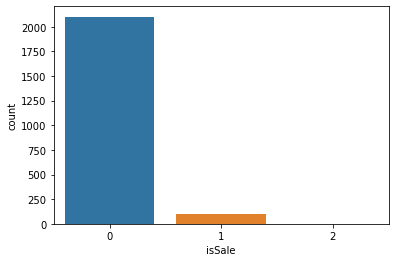

In [13]:
# visualize data
sns.countplot(x = 'isSale', data=leads_df)

In [14]:
# drop callDate
leads_df = leads_df.drop(columns=['callDate', 'callCount'])

# get the dummy variables
leads_df = pd.get_dummies(leads_df, drop_first=True, columns=['agentId', 'areaCode','site','supervisorId','shiftStartTime', 'state', 'dayOfWeek', 'medicareSeason', 'osr3'])

displayDataFrame(leads_df) 

isSale  atOffice  tenure  callStartTime        DNIS  agentId_00D  \
932315        0         0    13.0          55615  7273320765            0   
1241789       0         0     5.0          62314  7272950703            0   
657647        1         0    10.0          47130  7272950154            0   
1536712       0         0     4.0          37423  3612047899            0   
1001451       0         0     3.0          62666  8325364817            0   
...         ...       ...     ...            ...         ...          ...   
1131099       0         0     4.0          42180  8558046070            0   
378729        0         0    31.0          38875  8558201719            0   
1138933       0         0    17.0          68148  7273320765            0   
1080204       0         0    59.0          59725  7273259273            0   
1619127       0         1    38.0          55657  7272950703            0   

         agentId_00E  agentId_00G  agentId_00I  agentId_00J  ...  osr3_RS2  \
932315             0            0            0            0  ...         0   
1241789            0            0            0            0  ...         0   
657647             0            0            0            0  ...         0   
1536712            0            0            0            0  ...         0   
1001451            0            0            0            0  ...         0   
...              ...          ...          ...          ...  ...       ...   
1131099            0            0            0            0  ...         0   
378729             0            0            0            0  ...         0   
1138933            0            0            0            0  ...         0   
1080204            0            0            0            0  ...         0   
1619127            0            0            0            0  ...         0   

         osr3_RS3  osr3_TL1  osr3_UP2  osr3_US2  osr3_US3  osr3_US4  osr3_US5  \
932315          0         0         0         0         0         0         1   
1241789         0         0         0         1         0         0         0   
657647          0         0         0         0         0         1         0   
1536712         0         0         0         0         0         0         0   
1001451         0         0         0         0         0         0         0   
...           ...       ...       ...       ...       ...       ...       ...   
1131099         0         0         0         0         0         0         0   
378729          0         0         0         0         0         0         0   
1138933         0         0         0         0         0         0         1   
1080204         0         0         0         0         0         0         0   
1619127         0         0         0         1         0         0         0   

         osr3_WEB  osr3_Web  
932315          0         0  
1241789         0         0  
657647          0         0  
1536712         0         0  
1001451         0         0  
...           ...       ...  
1131099         0         0  
378729          0         0  
1138933         0         0  
1080204         0         0  
1619127         0         0  

[2200 rows x 1587 columns]

In [15]:
# fill in nans
leads_df = leads_df.fillna(leads_df.mean())

# input and outputs
X = leads_df.iloc[:, 1:]
y = leads_df.iloc[:, 0]
print(X)

         atOffice  tenure  callStartTime        DNIS  agentId_00D  \
932315          0    13.0          55615  7273320765            0   
1241789         0     5.0          62314  7272950703            0   
657647          0    10.0          47130  7272950154            0   
1536712         0     4.0          37423  3612047899            0   
1001451         0     3.0          62666  8325364817            0   
...           ...     ...            ...         ...          ...   
1131099         0     4.0          42180  8558046070            0   
378729          0    31.0          38875  8558201719            0   
1138933         0    17.0          68148  7273320765            0   
1080204         0    59.0          59725  7273259273            0   
1619127         1    38.0          55657  7272950703            0   

         agentId_00E  agentId_00G  agentId_00I  agentId_00J  agentId_00M  ...  \
932315             0            0            0            0            0  ...   
1241789  

In [16]:
# Test Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

In [17]:
# normalize inputs
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [18]:
# model parameters
EPOCHS = 10
BATCH_SIZE = 64
LEARNING_RATE = 0.001
INPUT_SIZE = len(X_train[0])

In [19]:
## dataloader

# train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))
# test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
test_data = testData(torch.FloatTensor(X_test))

In [20]:
# initialize dataloaders
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [21]:
# binary classification model
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # 1073 inputs
        self.layer_1 = nn.Linear(INPUT_SIZE, 4*INPUT_SIZE) 
        self.layer_2 = nn.Linear(4*INPUT_SIZE, 4*INPUT_SIZE)
        self.layer_out = nn.Linear(4*INPUT_SIZE, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(4*INPUT_SIZE)
        self.batchnorm2 = nn.BatchNorm1d(4*INPUT_SIZE)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [22]:
# check if on gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [23]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [24]:
# initialize model and move to gpu
model = binaryClassification()
#model.to(device)
print(model)
pos_weight = torch.tensor([28])
print(pos_weight)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=1586, out_features=6344, bias=True)
  (layer_2): Linear(in_features=6344, out_features=6344, bias=True)
  (layer_out): Linear(in_features=6344, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(6344, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(6344, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
tensor([28])


In [ ]:
# train model
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        #X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 6.93804 | Acc: 51.519
Epoch 002: | Loss: 1.88077 | Acc: 66.185
Epoch 003: | Loss: 0.65590 | Acc: 79.556
Epoch 004: | Loss: 0.38316 | Acc: 88.296


In [ ]:
# test model
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = y_test_pred #torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [ ]:
sale_av = 0
sale_c = 0
fail_av = 0
fail_c = 0

for i in range(len(y_pred_list)):
    if y_test[i] == 0:
        fail_av += y_pred_list[i]
        fail_c += 1
    else:
        sale_av += y_pred_list[i]
        sale_c += 1
    print(y_pred_list[i], y_test[i])
    
print(sale_av/sale_c, fail_av/fail_c)

In [ ]:
# test different agents
X_agents = [X.iloc[34457]]
displayDataFrame(X_agents, all_frame=True)
print(X_agents.columns.get_loc("agentId_00D"), X_agents.columns.get_loc("agentId_WA1"))
X_agents = X_agents.to_numpy()
print(X_agents)
for row in X_agents[:3]:
    X_agents.append(row)
X_agents = scaler.transform(X_agents)
test_agents = testData(torch.FloatTensor(X_agents))
test_agents_loader = DataLoader(dataset=test_agents, batch_size=1)

'''
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        print(X_batch)
        
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = y_test_pred #torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
'''

In [ ]:
best_agents_df = pd.read_csv('/Users/e.vargas/Desktop/Lead Routing/best_sellers.csv')
displayDataFrame(best_agents_df, all_frame=True)